<a href="https://colab.research.google.com/github/Jun-Liu-291/Deep-Learning-Model-/blob/master/Muli_layers_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def initialize_parameters(list_dimension):
  '''
  list_dimension[0]    -->  The size of the input data
  list_dimension[-1]   -->  The size of the output Y
  list_dimension[1:-1] -->  If there are hidden layers, the size for each hidden layers

  return:
  Parameters {"W1", "b1", ---, }
  '''
  np.random.seed(1)

  # initialize output dictionary
  parameters = {}
  num_layers = len(list_dimension) - 1

  for i in range(num_layers):
    temp_W = np.random.randn(list_dimension[i+1], list_dimension[i]) * 0.01
    temp_b = np.zeros((list_dimension[i+1], 1))

    parameters["W"+str(i+1)] = temp_W
    parameters["b"+str(i+1)] = temp_b

    assert(parameters['W' + str(i+1)].shape == (list_dimension[i+1], list_dimension[i]))
    assert(parameters['b' + str(i+1)].shape == (list_dimension[i+1], 1))
  
  return parameters

In [3]:
# test initialize_parameters function
temp_P = initialize_parameters([4, 3, 3, 1])

print(str(temp_P))

{'W1': array([[ 0.01624345, -0.00611756, -0.00528172, -0.01072969],
       [ 0.00865408, -0.02301539,  0.01744812, -0.00761207],
       [ 0.00319039, -0.0024937 ,  0.01462108, -0.02060141]]), 'b1': array([[0.],
       [0.],
       [0.]]), 'W2': array([[-0.00322417, -0.00384054,  0.01133769],
       [-0.01099891, -0.00172428, -0.00877858],
       [ 0.00042214,  0.00582815, -0.01100619]]), 'b2': array([[0.],
       [0.],
       [0.]]), 'W3': array([[0.01144724, 0.00901591, 0.00502494]]), 'b3': array([[0.]])}


In [4]:
# forward propagation module

# define linear forward propagation function
def linear_forward_propagation(A, W, b):
  '''
  A      --> activation from previous layer/ input data
  W      --> Weight of current layer
  b      --> Bias of current layer

  return:
  Z      --> Result of linear forward propagation
  cache  --> A python list containing "A", "W", "b" for backward pass efficiently
  '''

  Z = np.dot(W, A) + b

  assert(Z.shape == (W.shape[0], A.shape[1]))
  cache = (A, W, b)

  return Z, cache


In [5]:
# define activation function
def sigmoid(x):
  sol = 1.0 / (1.0 + np.exp(-x))
  cache = x

  return sol, cache

def relu(x):
  sol = np.maximum(0, x)
  cache = x

  return sol, cache

def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    Z = cache

    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)

    assert (dZ.shape == Z.shape)

    return dZ
def softmax(x):
  x_exp = np.exp(x)
  x_sum = np.sum(x_exp, axis = 1, keepdims = True)
  s = x_exp / x_sum

In [6]:
# activation function combine with linear forward propagation
def linear_activation_propagation(A_prev, W, b, activation):
  '''
  activation --> 2020-07-03 "sigmoid" or "relu"
  '''

  # get linear forward propagation Z and linear_cache
  Z, linear_cache = linear_forward_propagation(A_prev, W, b)

  # get the result of activation and activation_cache
  if(activation == "sigmoid"):
    A, activation_cache = sigmoid(Z)
  elif(activation == "relu"):
    A, activation_cache = relu(Z)

  assert (A.shape == (W.shape[0], A_prev.shape[1]))
  cache = (linear_cache, activation_cache)

  return A, cache

In [7]:
# Whole procesure of forward propogation of our Model
def whole_model_forward(X, parameters):
  '''
  All the activation function of each layers (except last layer) are "relu"
  Last layer's activation is "sigmoid"

  input:
  X          --> Input data, numpy array of shape (input size, number of examples)
  parameters --> output of initialize_parameters

  return:
  AL         --> last post-activation value
  caches     --> list of caches containing:
                  every cache of linear_relu_forward() (there are len-1 of them, indexed from 0 to L-2)
                  the cache of linear_sigmoid_forward() (there is one, indexed len-1)
  '''
  caches = []
  A = X
  L = len(parameters) // 2  

  for l in range(1, L):
    A_prev = A

    A, cache = linear_activation_propagation(A_prev, 
                                             parameters["W"+str(l)], 
                                             parameters["b"+str(l)], 
                                             activation = 'relu')
    caches.append(cache)
  
  AL, cache = linear_activation_propagation(A, 
                                            parameters["W"+str(L)], 
                                            parameters["b"+str(L)], 
                                            activation = 'sigmoid')
  caches.append(cache)

  # 2020-07-03 logistic regressiong only
  assert (AL.shape == (1, X.shape[1]))

  return AL, caches

In [8]:
# define compute_cost function
def compute_cost(AL, Y):
  '''
  input:
  AL --> prediction, output of whole_model_forward
  Y  --> Ground truth label of train data

  output:
  cost  --> loss function
  '''

  m = Y.shape[1]

  cost = - np.sum(np.dot(Y, np.log(AL.T)) + np.dot(1-Y, np.log(1-AL.T))) / m
  # make sure the cost's shape is a scaler
  cost = np.squeeze(cost)

  assert (cost.shape == ())

  return cost


In [9]:
# define linear_back function
def linear_backward(dZ, cache):
  '''
  input:
  dZ    --> Gradient of the loss function (cost) with repect to the linear output of current layer L
  cache --> tuple of values (A_prev, W, b), obtain through linear_forward_propagation function

  returns:
  dA_prev --> Gradient of the loss function (cost) with repect to the previous layer's activation
  dW      --> Gradient of the loss function (cost) with repect to the weight W
  db      --> Gradient of the loss function (cost) with repect to the bias b
  '''

  A_prev, W, b = cache
  m = A_prev.shape[1]

  dW = np.dot(dZ, A_prev.T) / m
  db = np.sum(dZ, axis = 1, keepdims = True) / m
  dA_prev = np.dot(W.T, dZ)

  assert (dA_prev.shape == A_prev.shape)
  assert (dW.shape == W.shape)
  assert (db.shape == b.shape)

  return dA_prev, dW, db

In [10]:
# define Linear activation backward function
def linear_activation_backward(dA, cache, activation):
  '''
  input:
  dA         --> Gradient of the loss function (cost) with repect to the activation output 
  cache      --> tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
  activation --> "sigmoid" or "relu"

  return:
  same as linear_backward
  '''

  linear_cache, activation_cache = cache

  dZ_temp = np.zeros(dA.shape)
  if activation == 'relu':
    dZ_temp = relu_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ_temp, linear_cache)
  elif activation == 'sigmoid':
    dZ_temp = sigmoid_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ_temp, linear_cache)

  

  return dA_prev, dW, db


In [11]:
# Whole procesure of backward propogation of our Model
def whole_model_backward(AL, Y, caches):
  '''
  input:
  AL     --> Output of final layer
  Y      --> Ground truth label of input training data
  caches --> output of whole_model_forward function, record every linear_cache and activation_cache
             through forward propogation

  returns:
  grads  --> A dictionary with the gradients "dA1" "dW1" "db1" ....
  '''

  grads = {}
  L = len(caches) # the number of layers
  m = AL.shape[1] # the number of input data
  Y = Y.reshape(AL.shape)

  dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

  current_cache = caches[-1]
  grads["dA"+str(L)], grads["dW"+str(L)], grads["db"+str(L)] = linear_activation_backward(dAL, current_cache, 'sigmoid')
  
  for l in reversed(range(L-1)):
    current_cache = caches[l]
    temp_dA_prev, temp_dW, temp_db = linear_activation_backward(grads['dA'+str(l+2)], current_cache, 'relu')
    grads["dA" + str(l + 1)] = temp_dA_prev
    grads["dW" + str(l + 1)] = temp_dW
    grads["db" + str(l + 1)] = temp_db

  return grads

In [12]:
# define update parameters
def updata_parameters(parameters, grads, learning_rate):
  '''
  input:
  parameters --> containing all W and b, initialized by initialize_parameters function
  grads      --> gradient obtained by whole_model_backward
  learning_rate

  returns:
  parameters
  '''

  L = len(parameters) // 2

  for l in range(L):
    parameters["W" + str(l+1)] =parameters["W" + str(l+1)]-learning_rate*grads["dW" + str(l+1)]
    parameters["b" + str(l+1)] =parameters["b" + str(l+1)]-learning_rate*grads["db" + str(l+1)]

  return parameters

In [13]:
# define optimize function
def optimize(parameters, X, Y, num_iterations, learning_rate, print_cost = False):
  costs = []

  for i in range(num_iterations):
    AL, caches = whole_model_forward(X, parameters)
    grads = whole_model_backward(AL, Y, caches)
    parameters = updata_parameters(parameters, grads, learning_rate)

    if(i % 100 == 0):
      cost = compute_cost(AL, Y)
      costs.append(cost)
    # print status
    if print_cost and i%100 == 0:
      print("Cost objective after %i iteration: %f" % (i, cost))

  return parameters, grads, costs

In [14]:
# build the model
def model(model_shape, Train_data, Train_labels, Test_data, Test_labels, num_iterations = 2000, learning_rate = 0.1, print_cost=False):
  # initialize parameter w and b
  parameters = initialize_parameters(model_shape)

  # Gradient descent
  parameters, grads, costs = optimize(parameters, Train_data, Train_labels, num_iterations, learning_rate, print_cost)

  # get prediction on Test_data & Train_data
  Yhat_test, temp_1 = whole_model_forward(Test_data, parameters)
  Yhat_train, temp_2 = whole_model_forward(Train_data, parameters)

  # Print train/test Errors
  print("train accuracy: {}".format(100 - np.mean(np.abs(Yhat_train - Train_labels)) * 100))
  print("test accuracy: {}".format(100 - np.mean(np.abs(Yhat_test - Test_labels)) * 100))


  # save results
  d = {"costs": costs,
         "Yhat_test": Yhat_test, 
         "Yhat_train" : Yhat_train, 
         "parameters": parameters,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
  return d

In [15]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [16]:
# load training set & test set
import os
from keras.preprocessing import image

base_path = '/content/drive/My Drive/dataset/cats&dogs/small_dataset'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

def get_data_labels(data_path, num):
  data = []
  labels = []
  i = 0
  for ani_name in os.listdir(data_path):
    temp_list = os.listdir(os.path.join(data_path, ani_name))

    for fn in temp_list[:num]:
      labels.append(i)
      img = image.load_img(os.path.join(data_path, ani_name, fn), target_size=(64, 64))

      x = image.img_to_array(img)
      data.append(x)
    i += 1
  
  return data, labels

x_train, y_train = get_data_labels(train_path, 256)
x_test, y_test = get_data_labels(test_path, 64)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print('Traning data shape is: ', x_train.shape)
print('Traning labels shape is: ', y_train.shape)
print('Test data shape is: ', x_test.shape)
print('Test labels shape is: ', y_test.shape)

Using TensorFlow backend.


Traning data shape is:  (512, 64, 64, 3)
Traning labels shape is:  (512,)
Test data shape is:  (128, 64, 64, 3)
Test labels shape is:  (128,)


y =  0
This is a dog


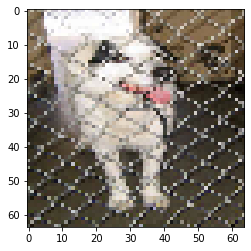

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from tensorflow import keras

# Example of a picture
index = 200
plt.imshow(image.array_to_img(x_train[index]))
print ("y = ", str(y_train[index]))
if(y_train[index] == 0): 
  print('This is a dog')
else:
  print('This is a cat')

In [18]:
# Flatten data and labels
m_train = x_train.shape[0]
m_test = x_test.shape[0]
num_px = x_test.shape[1]

data_train = x_train.reshape(x_train.shape[0], -1).T
data_test = x_test.reshape(x_test.shape[0], -1).T

labels_test = y_test.reshape(1, m_test)
labels_train = y_train.reshape(1, m_train)

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(data_train.shape))
print ("train_set_y shape: " + str(labels_train.shape))
print ("test_set_x shape: " + str(data_test.shape))
print ("test_set_y shape: " + str(labels_test.shape))

# rescale input data in (0,1)
data_test = data_test/255
data_train = data_train/255

Number of training examples: m_train = 512
Number of testing examples: m_test = 128
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (12288, 512)
train_set_y shape: (1, 512)
test_set_x shape: (12288, 128)
test_set_y shape: (1, 128)


In [19]:
model_shape = [12288, 1024, 256, 1]
d = model(model_shape, data_train, labels_train, data_test, labels_test, num_iterations = 2000, learning_rate = 0.001, print_cost=True)

Cost objective after 0 iteration: 0.693355
Cost objective after 100 iteration: 0.693238
Cost objective after 200 iteration: 0.693128
Cost objective after 300 iteration: 0.693022
Cost objective after 400 iteration: 0.692919
Cost objective after 500 iteration: 0.692818
Cost objective after 600 iteration: 0.692719
Cost objective after 700 iteration: 0.692621
Cost objective after 800 iteration: 0.692523
Cost objective after 900 iteration: 0.692424
Cost objective after 1000 iteration: 0.692324
Cost objective after 1100 iteration: 0.692221
Cost objective after 1200 iteration: 0.692118
Cost objective after 1300 iteration: 0.692011
Cost objective after 1400 iteration: 0.691894
Cost objective after 1500 iteration: 0.691774
Cost objective after 1600 iteration: 0.691651
Cost objective after 1700 iteration: 0.691528
Cost objective after 1800 iteration: 0.691401
Cost objective after 1900 iteration: 0.691272
train accuracy: 50.1020993836277
test accuracy: 50.023444203658954
